<a href="https://colab.research.google.com/github/Rogerx98/twsm-group-project/blob/main/SentenceBERT_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saved KFold Models:

Fold 0: https://drive.google.com/file/d/1pWi3VEvCwsbCqf5c5It6IlKxHOduNq_j/view?usp=sharing

Fold 1: https://drive.google.com/file/d/17GJDP_NzMYuxWv1i_2Ckhy7FucDrznJM/view?usp=sharing

Fold 2: https://drive.google.com/file/d/1-1-RsNbgMAUX0vAHsbxTMLvwUsu5o5vd/view?usp=sharing

Fold 3: https://drive.google.com/file/d/1P1-GJZL_t8EfdF_bmxHrL_0k_NzemePC/view?usp=sharing


# **Libraries**

In [1]:
!pip install transformers 
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 33.8 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
     |████████████████████████████████| 596 kB 62.1 MB/s 
     |████████████████████████████████| 101 kB 13.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import re

import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, TFBertModel, BertConfig, TFBertForSequenceClassification, TFDistilBertForSequenceClassification
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer


from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import BertForSequenceClassification
from tensorflow.keras.layers import Input, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, LSTM
from keras.layers.core import Activation, Dropout, Dense

import tensorflow as tf

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#since most of our numbers will be decimals :)

from tensorflow.keras.metrics import AUC

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Dataset**

In [4]:
#df = pd.read_csv("/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/twsm_project_corpus2.csv") #Roger main google acc
#df = pd.read_csv("/content/drive/MyDrive/twsm_project_corpus2.csv") #Roger second google acc
df = pd.read_csv("/content/drive/MyDrive/twsm_project_corpus_final.csv", index_col = 0) #Roger 3rd account (saving models)
#df = pd.read_csv("/content/drive/MyDrive/twsm_project_corpus2.csv", index_col = 0) #valentins drive
#df = pd.read_csv("/home/valentin_werner/TWSM_Lab_Team4/twsm_project_corpus0.csv", index_col = 0) on zeno
df.head(5)
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str]
df["accept"] = rejoined
df.head(10)

,text,accept,labels_str
0,The other part of our data consists of an undi...,[Data],Data
1,This list of actors can be interpreted to repr...,[Definition],Definition
2,The two samples were compared on all study var...,"[Method, Theory]",Method Theory
3,This is supported by a more recent report by ...,[RelationToLiterature],RelationToLiterature
4,", the false noise parameter C was misstated by...",[Definition],Definition
5,"In the strategic management literature, the na...",[RelationToLiterature],RelationToLiterature
6,"No such link was found however, but, according...",[FutureWork],FutureWork
7,The problem is that the timeliness of the data...,"[Data, Limitation]",Data Limitation
8,The social sciences differ from the physical s...,[RelationToLiterature],RelationToLiterature
9,Browne et al. START_CITE [3] END_CITE CITE_b...,[RelationToLiterature],RelationToLiterature


## **Preprocess Text**

In [5]:
# define pre_process
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

In [6]:
#apply preprocess 
df["clean_text"] = df["text"].apply(pre_process)

In [7]:
#sample of the original df
df["text"][3]

'This is supported by a more recent report by  START_CITE West and Curtis (2006) END_CITE  CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [8]:
#same sample but preprocessed
df["clean_text"][3]

'this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [9]:
#check "cites", consider deletion of specific characters and signs
pd.set_option('display.max_colwidth', None)

clean_text = df[df['clean_text'].str.contains('cite')]

In [10]:
df["clean_text"]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                               the other part of our data consists of an undirected social graph.
1                                                                                                                                                                                                                                                                                                                                                                                                                   this list of actors can be interpreted to represent the most impo

In [11]:
#cleaning cites
import re

new_text = [re.sub("start_cite|end_cite|cite_\w+", "", text) for text in df["clean_text"]]
df["clean_text"] = new_text
df["clean_text"][0:5]

0                                                                                                                             the other part of our data consists of an undirected social graph.
1                                                                 this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.
2                                                                                  the two samples were compared on all study variables and on age, gender, position, and organizational tenure.
3    this is supported by a more recent report by  west and curtis (2006)   , which found significant differences between women and men academics, including disparities in tenure and salaries.
4                                                             , the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).
Name: clean_text, dtype: object

## **Max_len decision**

Text(0, 0.5, 'Word count')

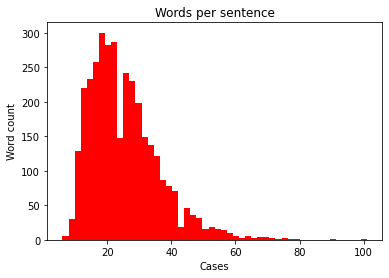

In [12]:
#Count words per sentence so we can set an appropiate max_len
word_list = [len(x.split()) for x in df["clean_text"].tolist()]
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
n, bins, patches = ax.hist(word_list, bins=50, histtype='bar')

#ax.set_xticklabels([n], rotation='vertical')

for patch in patches:
    patch.set_facecolor('r')

plt.title("Words per sentence")
plt.xlabel('Cases')
plt.ylabel('Word count')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


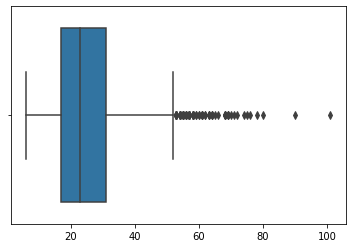

In [13]:
sns.boxplot(word_list)

In [14]:
#maximum length of 75 is fine!
np.count_nonzero(np.array(word_list) >= 75)

6

# **Keras Model**

In [15]:
#lets turn "accept" into a column that properly lists the labels (right now it is a string of a list instead of a list of strings)
rejoined = np.array([row.split(" ") for row in df.labels_str])
df["accept"] = rejoined
df_new = df[["clean_text", "accept"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [16]:
rejoined

array([list(['Data']), list(['Definition']), list(['Method', 'Theory']),
       ..., list(['RelationToLiterature']), list(['Theory']),
       list(['Definition'])], dtype=object)

In [17]:
df_new = df_new.reset_index().drop(columns = "index")
df_new.columns = ["text", "label"]

In [18]:
df_new.head()

,text,label
0,the other part of our data consists of an undirected social graph.,[Data]
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,[Definition]
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[Method, Theory]"
3,"this is supported by a more recent report by west and curtis (2006) , which found significant differences between women and men academics, including disparities in tenure and salaries.",[RelationToLiterature]
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).",[Definition]


## **Cross-validation set up and label encoding**

In [19]:
# First Split for Train and Test
#we should stratify, but we have some groups that have only one
train_df, test_df = train_test_split(df_new, test_size=0.1, random_state= 0)#, stratify = df_new.label.values)

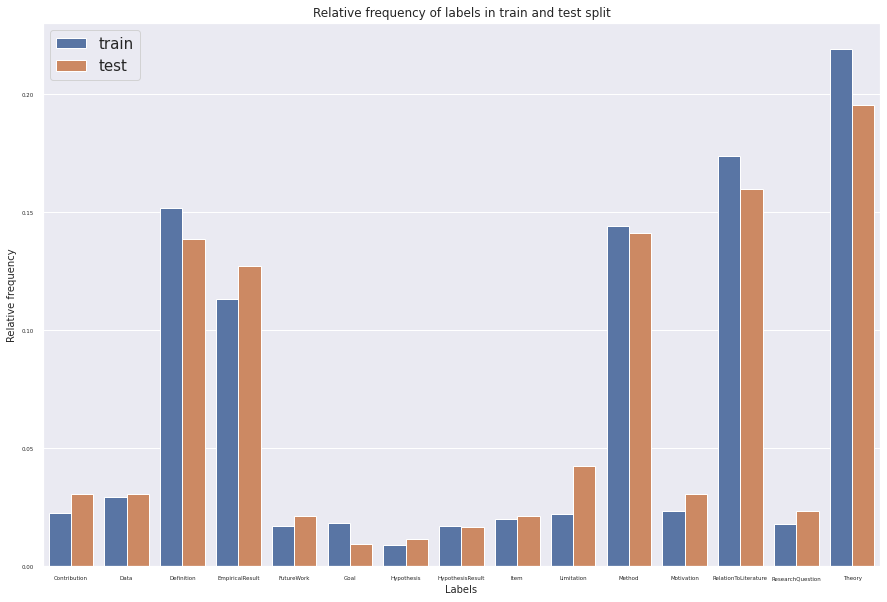

In [20]:
#Since we cannot use stratified train test split, because we have groups with only one combination, lets see what unstratisfied train-test looks like
train_df_exploded = train_df.explode("label")
test_df_exploded = test_df.explode("label")

comparison_1 = train_df_exploded.groupby("label").count().reset_index()
comparison_1.columns = ["label", "relative_frequency"]
comparison_1["split"] = "train"
comparison_1["relative_frequency"] = comparison_1.relative_frequency / sum(comparison_1.relative_frequency)
comparison_2 = test_df_exploded.groupby("label").count().reset_index()
comparison_2.columns = ["label", "relative_frequency"]
comparison_2["split"] = "test"
comparison_2["relative_frequency"] = comparison_2.relative_frequency / sum(comparison_2.relative_frequency)

comp = pd.concat([comparison_1, comparison_2])
plt.figure(figsize = (15,10))
sns.set(font_scale = 0.5)
sns.barplot(x = "label", y = "relative_frequency", data = comp, hue = "split")
plt.xlabel("Labels", fontsize = 10)
plt.ylabel("Relative frequency", fontsize = 10)
plt.legend(fontsize = 15)
plt.title("Relative frequency of labels in train and test split", fontsize = 12);
#We do have some inbalanced groups, but overall this should work out alright

In [21]:
#KFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(train_df)

4

In [22]:
#Encode labels for stratifying
mlb = MultiLabelBinarizer()
accept_MLB = mlb.fit_transform(train_df["label"])
# Getting a sense of how the tags data looks like
print(accept_MLB[0])
print(mlb.inverse_transform(accept_MLB[0].reshape(1,-1)))
print(mlb.classes_)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[('Definition',)]
['Contribution' 'Data' 'Definition' 'EmpiricalResult' 'FutureWork' 'Goal'
 'Hypothesis' 'HypothesisResult' 'Item' 'Limitation' 'Method' 'Motivation'
 'RelationToLiterature' 'ResearchQuestion' 'Theory']


In [23]:
train_df = train_df.reset_index().drop(columns = "index")

In [24]:
#Create 4 folds in a new column of the df
for i,(x,y) in enumerate(skf.split(X=train_df.text, y=np.argmax(accept_MLB, axis=1))):
    train_df.loc[y,'fold']=i
train_df.fold.value_counts()

1.0    775
2.0    775
0.0    775
3.0    774
Name: fold, dtype: int64

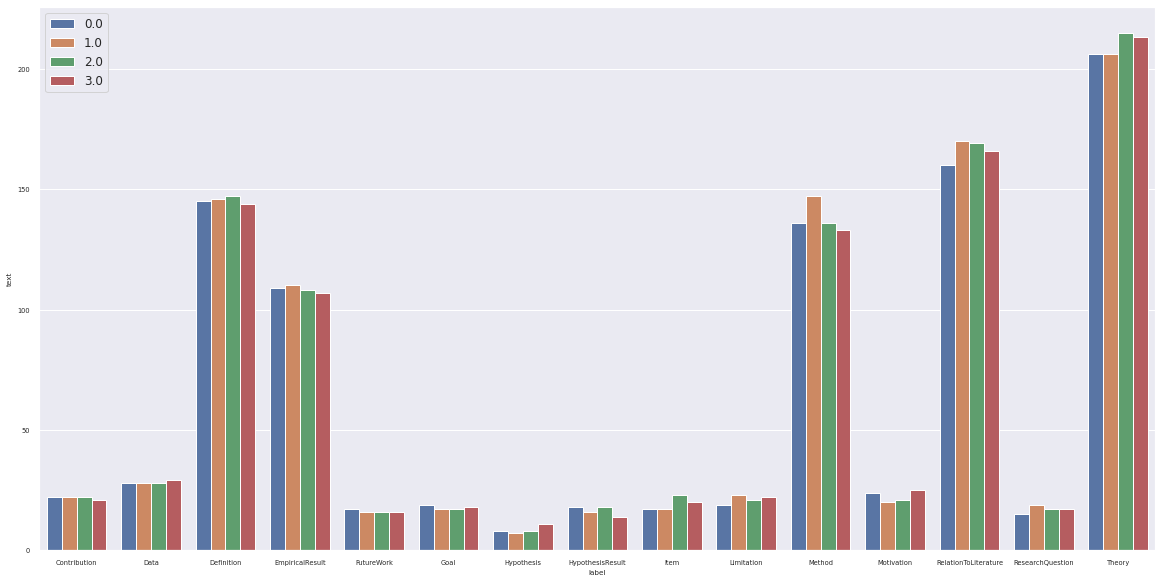

In [25]:
#Fold check
fold_check = train_df.explode("label")
fold_check = fold_check.groupby(["fold", "label"]).text.count().reset_index()
plt.figure(figsize = (20,10))
sns.set(font_scale = 0.6)
sns.barplot(x = "label", y = "text", hue = "fold", data = fold_check)
plt.legend(fontsize = 12);
#This is a nice split, we would expect similar performance within the folds

## **Def necessary functions and utilities**

In [26]:
#encoding labels with keras Lookup Layer
terms = tf.ragged.constant(df_new["label"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f"Vocabulary: {vocab}")
#the UNK token will always also be returned.

Vocabulary: ['[UNK]', 'Theory', 'RelationToLiterature', 'Definition', 'Method', 'EmpiricalResult', 'Data', 'Motivation', 'Limitation', 'Contribution', 'Item', 'ResearchQuestion', 'Goal', 'FutureWork', 'HypothesisResult', 'Hypothesis']


In [27]:
#Example
sample_label = df_new["label"].iloc[2]
label_binarized = lookup([sample_label])
label_binarized, sample_label
#Note: Unlike the OHE with sklearn, this is not ordered alphabetically but in the order we can find below (including the UNK token)

(<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
 array([[0.000000, 1.000000, 0.000000, 0.000000, 1.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000]], dtype=float32)>,
 ['Method', 'Theory'])

In [28]:
#Our Config (so we can reference this values in later code and avoid spaghetti)
seed = 0
epochs = 20
max_length = 75
batch_size = 4
learning_rate = 2e-5
base_model = "bert-large-uncased"

In [29]:
#Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
def tok(x): return tokenizer(x, padding = True, truncation = True, return_tensors = "tf", max_length = max_length)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [30]:
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["label"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        #because tokenizing becomes more dificult afterwards (hugginface clashes a little with keras), I already tokenize here
        ((tok(list(dataframe.text))["input_ids"], tok(list(dataframe.text))["attention_mask"])
        #not using the token type since we are not using special tokens anyways
        ,label_binarized)
    )
    #take batches randomly along the whole dataset
    dataset = dataset.shuffle(batch_size * ((dataframe.shape[0] // batch_size) + 1)) if is_train else dataset
    return dataset.batch(batch_size)

In [31]:
#get datasets
#train_dataset = make_dataset(train_df, is_train=True) #in for loop for cv
#validation_dataset = make_dataset(val_df, is_train=False) #in for loop for cv
test_dataset = make_dataset(test_df, is_train=False)

In [32]:
#Useful to decode outputs
def get_labels_out(dataset):
    labels = []
    for element in dataset:
        for arr in element[1]:
            labels.append(np.array(arr))
    labels = np.asarray(labels)
    return labels

In [33]:
#Multi Label Accuracy For Multiple Labels Classification Models (https://data4thought.com/toxic_comments_transformer.html)
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [34]:
#Def model network
def build_model():
    
    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    
    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)
    x = bert(input_ids = input_ids, attention_mask = input_mask) 

    #this is for finetuning
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(0.15)(x)
    out = tf.keras.layers.Dense(lookup.vocabulary_size(), activation='softmax')(x)
    
    model = tf.keras.Model(inputs = [input_ids, input_mask], 
                           outputs = out)
    return model

In [35]:
#Def scheduler for learning rate decay for different multipliers
def scheduler_example(epoch, multiplier):
    if epoch == 0: return learning_rate * 0.15
    if epoch == 1: return learning_rate * 0.3
    else: return learning_rate / (epoch**multiplier) # more epochs = lower the number

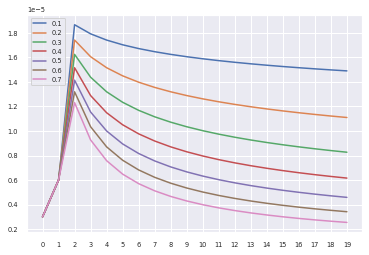

In [36]:
#Showing the effects of learning rate scheduling
e20m01 = [scheduler_example(epoch, 0.1) for epoch in range(20)]
e20m02 = [scheduler_example(epoch, 0.2) for epoch in range(20)]
e20m03 = [scheduler_example(epoch, 0.3) for epoch in range(20)]
e20m04 = [scheduler_example(epoch, 0.4) for epoch in range(20)]
e20m05 = [scheduler_example(epoch, 0.5) for epoch in range(20)]
e20m06 = [scheduler_example(epoch, 0.6) for epoch in range(20)]
e20m07 = [scheduler_example(epoch, 0.7) for epoch in range(20)]

plt.plot(e20m01, label = "0.1")
plt.plot(e20m02, label = "0.2")
plt.plot(e20m03, label = "0.3")
plt.plot(e20m04, label = "0.4")
plt.plot(e20m05, label = "0.5")
plt.plot(e20m06, label = "0.6")
plt.plot(e20m07, label = "0.7")
plt.legend()
plt.xticks(range(20)); 
#something between 0.2 and 0.3 may works out well 

In [37]:
#Def scheduler for learning rate decay
def scheduler(epoch):
    if epoch == 0: return learning_rate * 0.15
    if epoch == 1: return learning_rate * 0.3
    else: return learning_rate / (epoch**0.25) # more epochs = lower the number

## **For looping the model through k-folds**

We had to divide the for loop between different cells because Google Collab limits the RAM run

**Fold 0**

In [ ]:
#histories = []
#scores = []

for fold in range(0,1):
    print(f"====== FOLD RUNNING {fold}======")
    
    X_train = train_df.loc[train_df['fold'] != fold]['text']
    y_train = train_df.loc[train_df['fold'] != fold]['label']
    
    X_test = train_df.loc[train_df['fold'] == fold]['text']
    y_test = train_df.loc[train_df['fold'] == fold]['label']
    
    train_df_loop = pd.concat([X_train, y_train], axis=1)
    test_df_loop = pd.concat([X_test, y_test], axis=1)

    print("Tokenizing, generating datasets")
    #get datasets
    train_dataset = make_dataset(train_df_loop, is_train=True)
    validation_dataset = make_dataset(test_df_loop, is_train=False)

    print("Model Creation")
    model = build_model()
    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "binary_crossentropy",
            metrics = [
              multi_label_accuracy,
              "binary_accuracy", 
              AUC(name="average_precision", curve="PR", multi_label=True)
              ]
        )
    #model.summary()

    callback_es = tf.keras.callbacks.EarlyStopping(monitor="val_multi_label_accuracy",#'val_categorical_accuracy', 
                                               patience=3,
                                               mode='max', 
                                               verbose=1,
                                               restore_best_weights=True)

    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

    callback_save = tf.keras.callbacks.ModelCheckpoint(
        #valentin's path
            f'/content/drive/MyDrive/SentenceBert_fold{fold}.h5', monitor='val_multi_label_accuracy',
            #'/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/keras_model/RogerSentenceBert2.h5', monitor='val_multi_label_accuracy',
            #"/content/drive/MyDrive/Output models Bert/RogerSentenceBert2.h5", monitor='val_multi_label_accuracy',
            verbose=1, save_best_only=True,
            save_weights_only=True, mode='max', 
            save_freq='epoch')

    hist = model.fit(train_dataset, 
                epochs = epochs,
                shuffle=True,
                callbacks = [callback_lr,
                              callback_es,
                              callback_save,
                            ],
                batch_size = batch_size,
                validation_data = validation_dataset
              )

    del model, hist

    #Clearing backend session
    K.clear_session()
    print("Backend Cleared")

====== FOLD RUNNING 0======
Tokenizing, generating datasets
Model Creation


Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.



Epoch 1: LearningRateScheduler setting learning rate to 3e-06.
Epoch 1/20
581/581 [==============================] - ETA: 0s - loss: 0.2328 - multi_label_accuracy: 0.0972 - binary_accuracy: 0.9257 - average_precision: 0.1449
Epoch 1: val_multi_label_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/SentenceBert_fold0.h5
581/581 [==============================] - 243s 361ms/step - loss: 0.2328 - multi_label_accuracy: 0.0972 - binary_accuracy: 0.9257 - average_precision: 0.1449 - val_loss: 0.1826 - val_multi_label_accuracy: 0.2500 - val_binary_accuracy: 0.9348 - val_average_precision: 0.2577 - lr: 3.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 6e-06.
Epoch 2/20
581/581 [==============================] - ETA: 0s - loss: 0.1819 - multi_label_accuracy: 0.2685 - binary_accuracy: 0.9334 - average_precision: 0.2644
Epoch 2: val_multi_label_accuracy improved from 0.25000 to 0.28222, saving model to /content/drive/MyDrive/SentenceBert_fold0.h5
5

**Fold 1**

In [ ]:
#histories = []
#scores = []

for fold in range(1,2):
    print(f"====== FOLD RUNNING {fold}======")
    
    X_train = train_df.loc[train_df['fold'] != fold]['text']
    y_train = train_df.loc[train_df['fold'] != fold]['label']
    
    X_test = train_df.loc[train_df['fold'] == fold]['text']
    y_test = train_df.loc[train_df['fold'] == fold]['label']
    
    train_df_loop = pd.concat([X_train, y_train], axis=1)
    test_df_loop = pd.concat([X_test, y_test], axis=1)

    print("Tokenizing, generating datasets")

    #get datasets
    train_dataset = make_dataset(train_df_loop, is_train=True)
    validation_dataset = make_dataset(test_df_loop, is_train=False)

    print("Model Creation")
    model = build_model()
    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "binary_crossentropy",
            metrics = [
              multi_label_accuracy,
              "binary_accuracy", 
              AUC(name="average_precision", curve="PR", multi_label=True)
              ]
        )

    callback_es = tf.keras.callbacks.EarlyStopping(monitor="val_multi_label_accuracy",#'val_categorical_accuracy', 
                                               patience=3,
                                               mode='max', 
                                               verbose=1,
                                               restore_best_weights=True)

    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

    callback_save = tf.keras.callbacks.ModelCheckpoint(
        #valentin's path
            f'/content/drive/MyDrive/SentenceBert_fold{fold}.h5', monitor='val_multi_label_accuracy',
            #'/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/keras_model/RogerSentenceBert2.h5', monitor='val_multi_label_accuracy',
            #"/content/drive/MyDrive/Output models Bert/RogerSentenceBert2.h5", monitor='val_multi_label_accuracy',
            verbose=1, save_best_only=True,
            save_weights_only=True, mode='max', 
            save_freq='epoch')

    hist = model.fit(train_dataset, 
                epochs = epochs,
                shuffle=True,
                callbacks = [callback_lr,
                              callback_es,
                              callback_save,
                            ],
                batch_size = batch_size,
                validation_data = validation_dataset
              )
    
    del model, hist 
    
    #Clearing backend session
    K.clear_session()
    print("Backend Cleared")

====== FOLD RUNNING 1======
Tokenizing, generating datasets
Model Creation


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.



Epoch 1: LearningRateScheduler setting learning rate to 3e-06.
Epoch 1/20
581/581 [==============================] - ETA: 0s - loss: 0.2285 - multi_label_accuracy: 0.1054 - binary_accuracy: 0.9264 - average_precision: 0.1511
Epoch 1: val_multi_label_accuracy improved from -inf to 0.25644, saving model to /content/drive/MyDrive/SentenceBert_fold1.h5
581/581 [==============================] - 256s 383ms/step - loss: 0.2285 - multi_label_accuracy: 0.1054 - binary_accuracy: 0.9264 - average_precision: 0.1511 - val_loss: 0.1910 - val_multi_label_accuracy: 0.2564 - val_binary_accuracy: 0.9277 - val_average_precision: 0.2391 - lr: 3.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 6e-06.
Epoch 2/20
581/581 [==============================] - ETA: 0s - loss: 0.1807 - multi_label_accuracy: 0.2775 - binary_accuracy: 0.9339 - average_precision: 0.2756
Epoch 2: val_multi_label_accuracy improved from 0.25644 to 0.28909, saving model to /content/drive/MyDrive/SentenceBert_fold1.h5
5

**Fold 2**

In [ ]:
#histories = []
#scores = []

for fold in range(2,3):
    print(f"====== FOLD RUNNING {fold}======")
    
    X_train = train_df.loc[train_df['fold'] != fold]['text']
    y_train = train_df.loc[train_df['fold'] != fold]['label']
    
    X_test = train_df.loc[train_df['fold'] == fold]['text']
    y_test = train_df.loc[train_df['fold'] == fold]['label']
    
    train_df_loop = pd.concat([X_train, y_train], axis=1)
    test_df_loop = pd.concat([X_test, y_test], axis=1)

    print("Tokenizing, generating datasets")

    #get datasets
    train_dataset = make_dataset(train_df_loop, is_train=True)
    validation_dataset = make_dataset(test_df_loop, is_train=False)

    print("Model Creation")
    model = build_model()
    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "binary_crossentropy",
            metrics = [
              multi_label_accuracy,
              "binary_accuracy", 
              AUC(name="average_precision", curve="PR", multi_label=True)
              ]
        )

    callback_es = tf.keras.callbacks.EarlyStopping(monitor="val_multi_label_accuracy",#'val_categorical_accuracy', 
                                               patience=3,
                                               mode='max', 
                                               verbose=1,
                                               restore_best_weights=True)

    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

    callback_save = tf.keras.callbacks.ModelCheckpoint(
        #valentin's path
            f'/content/drive/MyDrive/SentenceBert_fold{fold}.h5', monitor='val_multi_label_accuracy',
            #'/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/keras_model/RogerSentenceBert2.h5', monitor='val_multi_label_accuracy',
            #"/content/drive/MyDrive/Output models Bert/RogerSentenceBert2.h5", monitor='val_multi_label_accuracy',
            verbose=1, save_best_only=True,
            save_weights_only=True, mode='max', 
            save_freq='epoch')

    hist = model.fit(train_dataset, 
                epochs = epochs,
                shuffle=True,
                callbacks = [callback_lr,
                              callback_es,
                              callback_save,
                            ],
                batch_size = batch_size,
                validation_data = validation_dataset
              )
    
    del model, hist 
    
    #Clearing backend session
    K.clear_session()
    print("Backend Cleared")

====== FOLD RUNNING 2======
Tokenizing, generating datasets
Model Creation


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.



Epoch 1: LearningRateScheduler setting learning rate to 3e-06.
Epoch 1/20
581/581 [==============================] - ETA: 0s - loss: 0.2435 - multi_label_accuracy: 0.0856 - binary_accuracy: 0.9262 - average_precision: 0.1425
Epoch 1: val_multi_label_accuracy improved from -inf to 0.24270, saving model to /content/drive/MyDrive/SentenceBert_fold2.h5
581/581 [==============================] - 252s 375ms/step - loss: 0.2435 - multi_label_accuracy: 0.0856 - binary_accuracy: 0.9262 - average_precision: 0.1425 - val_loss: 0.1908 - val_multi_label_accuracy: 0.2427 - val_binary_accuracy: 0.9299 - val_average_precision: 0.2519 - lr: 3.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 6e-06.
Epoch 2/20
581/581 [==============================] - ETA: 0s - loss: 0.1783 - multi_label_accuracy: 0.2694 - binary_accuracy: 0.9334 - average_precision: 0.2874
Epoch 2: val_multi_label_accuracy improved from 0.24270 to 0.28909, saving model to /content/drive/MyDrive/SentenceBert_fold2.h5
5

**Fold 3**

In [ ]:
#histories = []
#scores = []

for fold in range(3,4):
    print(f"====== FOLD RUNNING {fold}======")
    
    X_train = train_df.loc[train_df['fold'] != fold]['text']
    y_train = train_df.loc[train_df['fold'] != fold]['label']
    
    X_test = train_df.loc[train_df['fold'] == fold]['text']
    y_test = train_df.loc[train_df['fold'] == fold]['label']
    
    train_df_loop = pd.concat([X_train, y_train], axis=1)
    test_df_loop = pd.concat([X_test, y_test], axis=1)

    print("Tokenizing, generating datasets")

    #get datasets
    train_dataset = make_dataset(train_df_loop, is_train=True)
    validation_dataset = make_dataset(test_df_loop, is_train=False)

    print("Model Creation")
    model = build_model()
    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "binary_crossentropy",
            metrics = [
              multi_label_accuracy,
              "binary_accuracy", 
              AUC(name="average_precision", curve="PR", multi_label=True)
              ]
        )

    callback_es = tf.keras.callbacks.EarlyStopping(monitor="val_multi_label_accuracy",#'val_categorical_accuracy', 
                                               patience=3,
                                               mode='max', 
                                               verbose=1,
                                               restore_best_weights=True)

    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

    callback_save = tf.keras.callbacks.ModelCheckpoint(
        #valentin's path
            f'/content/drive/MyDrive/SentenceBert_fold{fold}.h5', monitor='val_multi_label_accuracy',
            #'/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/keras_model/RogerSentenceBert2.h5', monitor='val_multi_label_accuracy',
            #"/content/drive/MyDrive/Output models Bert/RogerSentenceBert2.h5", monitor='val_multi_label_accuracy',
            verbose=1, save_best_only=True,
            save_weights_only=True, mode='max', 
            save_freq='epoch')

    hist = model.fit(train_dataset, 
                epochs = epochs,
                shuffle=True,
                callbacks = [callback_lr,
                              callback_es,
                              callback_save,
                            ],
                batch_size = batch_size,
                validation_data = validation_dataset
              )
    
    del model, hist 
    
    #Clearing backend session
    K.clear_session()
    print("Backend Cleared")

====== FOLD RUNNING 3======
Tokenizing, generating datasets
Model Creation


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.



Epoch 1: LearningRateScheduler setting learning rate to 3e-06.
Epoch 1/20
582/582 [==============================] - ETA: 0s - loss: 0.2292 - multi_label_accuracy: 0.0906 - binary_accuracy: 0.9259 - average_precision: 0.1424
Epoch 1: val_multi_label_accuracy improved from -inf to 0.20232, saving model to /content/drive/MyDrive/SentenceBert_fold3.h5
582/582 [==============================] - 262s 393ms/step - loss: 0.2292 - multi_label_accuracy: 0.0906 - binary_accuracy: 0.9259 - average_precision: 0.1424 - val_loss: 0.1914 - val_multi_label_accuracy: 0.2023 - val_binary_accuracy: 0.9301 - val_average_precision: 0.2229 - lr: 3.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 6e-06.
Epoch 2/20
582/582 [==============================] - ETA: 0s - loss: 0.1818 - multi_label_accuracy: 0.2642 - binary_accuracy: 0.9325 - average_precision: 0.2646
Epoch 2: val_multi_label_accuracy improved from 0.20232 to 0.26160, saving model to /content/drive/MyDrive/SentenceBert_fold3.h5
5

## **Validation Dataset - Accuracy Mean of Folds**

In [ ]:
scores_val = []

for fold in range(4):
    print(f"====== EVAL MODELS {fold}======")
    
    X_test = train_df.loc[train_df['fold'] == fold]['text']
    y_test = train_df.loc[train_df['fold'] == fold]['label']

    test_df_loop = pd.concat([X_test, y_test], axis=1)

    print("Tokenizing, generating dataset")

    #get datasets
    validation_dataset = make_dataset(test_df_loop, is_train=False)

    print("Model Import")
    model = build_model()
    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "binary_crossentropy",
            metrics = [
              multi_label_accuracy,
              "binary_accuracy", 
              AUC(name="average_precision", curve="PR", multi_label=True)
              ]
        )
    
    model.load_weights(f'/content/drive/MyDrive/SentenceBert_fold{fold}.h5')
    
    # prediction on val
    print("prediction on validation data")
    test_labels = get_labels_out(validation_dataset)
    preds = model.predict(validation_dataset)
    score = multi_label_accuracy(test_labels, preds)
    scores_val.append(score)
    
    del model

    #Clearing backend session
    K.clear_session()
    print("Backend Cleared")

print("\n\n\n the final average multilabel accuracy for validation dataset is ", np.mean(scores_val))

====== EVAL MODELS 0======
Tokenizing, generating dataset
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on validation data
Backend Cleared
====== EVAL MODELS 1======
Tokenizing, generating dataset
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on validation data
Backend Cleared
====== EVAL MODELS 2======
Tokenizing, generating dataset
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on validation data
Backend Cleared
====== EVAL MODELS 3======
Tokenizing, generating dataset
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on validation data
Backend Cleared



 the final average multilabel accuracy for validation dataset is  0.40303576


## **Test prediction with the 4 K Fold Models**

In [ ]:
scores_test = []
pred_test = []

for fold in range(4):
    print(f"====== PRED MODELS {fold}======")

    print("Model Import")
    model = build_model()
    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "binary_crossentropy",
            metrics = [
              multi_label_accuracy,
              "binary_accuracy", 
              AUC(name="average_precision", curve="PR", multi_label=True)
              ]
        )
    
    model.load_weights(f'/content/drive/MyDrive/SentenceBert_fold{fold}.h5')
    
    
    # prediction on test
    print("prediction on test data")
    test_labels = get_labels_out(test_dataset)
    preds = model.predict(test_dataset)
    # store preds
    pred_test.append(preds)
    scores = multi_label_accuracy(test_labels, preds)
    scores_test.append(scores)

    
    
    del model


    #Clearing backend session
    K.clear_session()
    print("Backend Cleared")

preds_avg = np.mean(np.array(pred_test),axis=0)
preds_avg[preds_avg >= 0.5] = 1
preds_avg[preds_avg < 0.5] = 0
preds_tf = tf.convert_to_tensor(preds_avg, dtype=tf.float32)
labels_tf = tf.ragged.constant(test_df["label"].values)
label_binarized = lookup(labels_tf)
multi_label_accuracy(label_binarized, preds_tf).numpy()

print("the final average multilabel accuracy for test dataset is ", np.mean(scores_test))
print("the final ensembled multilabel accuracy for test dataset is ", multi_label_accuracy(label_binarized, preds_tf).numpy())

====== PRED MODELS 0======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on test data
Backend Cleared
====== PRED MODELS 1======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on test data
Backend Cleared
====== PRED MODELS 2======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on test data
Backend Cleared
====== PRED MODELS 3======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on test data
Backend Cleared
the final average multilabel accuracy for test dataset is  0.36666667
the final ensembled multilabel accuracy for test dataset is  0.3768116


# **Predicting the labeling of an example sentence**

In [95]:
sentence = "Iacob and Jonkers' method was formalized using the HPRM formalism, implemented in a tool and applied by modeling three application components and five services of a GIS of a Swedish utility company."

def tok_sen(x): return tokenizer(x, padding = "max_length", truncation = True, return_tensors = "tf", max_length = max_length)

sentence = [tok_sen(sentence)["input_ids"], tok_sen(sentence)["attention_mask"]]

pred_test = []

for fold in range(4):
    print(f"====== PRED MODELS {fold}======")

    print("Model Import")
    model = build_model()
    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss = "binary_crossentropy",
            metrics = [
              multi_label_accuracy,
              "binary_accuracy", 
              AUC(name="average_precision", curve="PR", multi_label=True)
              ]
        )
    
    model.load_weights(f'/content/drive/MyDrive/SentenceBert_fold{fold}.h5')
    
    
    # prediction on test
    print("prediction on example sentence")
    preds = model.predict(sentence)
    # store preds
    pred_test.append(preds)
    del model

    #Clearing backend session
    K.clear_session()
    print("Backend Cleared")

preds_avg = np.mean(np.array(pred_test),axis=0)
preds = np.mean(np.array(pred_test),axis=0)
preds_avg[preds_avg >= 0.5] = 1
preds_avg[preds_avg < 0.5] = 0

print(f"the model predicted {preds} this means the labels are {[vocab[idx] for idx in [i for i in range(preds_avg.reshape(-1).shape[0]) if preds_avg.reshape(-1)[i] == 1]]}")

====== PRED MODELS 0======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on example sentence
Backend Cleared
====== PRED MODELS 1======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on example sentence
Backend Cleared
====== PRED MODELS 2======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on example sentence
Backend Cleared
====== PRED MODELS 3======
Model Import


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


prediction on example sentence
Backend Cleared
the model predicted [[0.000031 0.156542 0.000219 0.266398 0.574757 0.000140 0.000143 0.001089
  0.000016 0.000049 0.000027 0.000046 0.000210 0.000026 0.000176 0.000132]] this means the labels are ['Method']


# General tries of trial and error 
# 1.

* learning rate: 4e-5
* epochs: 8
* model: 1st try roger
* loss: 0.0611 - multi_label_accuracy: 0.6737 - binary_accuracy: 0.9726 - average_precision: 0.7886 - val_loss: 0.2770 - **val_multi_label_accuracy: 0.3220** - val_binary_accuracy: 0.9197 - val_average_precision: 0.3875

# 2.

* *learning rate: 5e-5 #horrendous*

# 3.

* learning rate: 3e-5
* epochs: 8
* model: 2nd try roger 
* loss: 0.1482 - multi_label_accuracy: 0.4215 - binary_accuracy: 0.9468 - average_precision: 0.5725 - val_loss: 0.2975 - **val_multi_label_accuracy: 0.31439** - val_binary_accuracy: 0.9195 - val_average_precision: 0.0786

# 4

* learning rate: 4e-5
* epochs: 8
* model: 2nd try roger (Play with 0.1-0,2 dropout)
* loss: 0.0317 - multi_label_accuracy: 0.6858 - binary_accuracy: 0.9747 - average_precision: 0.8811 - val_loss: 0.2564 - **val_multi_label_accuracy: 0.3447** - val_binary_accuracy: 0.9256 - val_average_precision: 0.3905 

# 5

* learning rate: 1e-5
* epochs: 8
* model: 1st try roger 0,2 dropout
* loss: 0.0816 - multi_label_accuracy: 0.5896 - binary_accuracy: 0.9648 - average_precision: 0.7828 - val_loss: 0.2149 - **val_multi_label_accuracy: 0.3333** - val_binary_accuracy: 0.9258 - val_average_precision: 0.3763

# 6

* learning rate: 2e-5
* epochs: 8
* model: 1st try roger 0,2 dropout
* loss: 0.0194 - multi_label_accuracy: 0.7013 - binary_accuracy: 0.9766 - average_precision: 0.8919 - val_loss: 0.2766 - **val_multi_label_accuracy: 0.3447** - val_binary_accuracy: 0.9234 - val_average_precision: 0.3933

# 7 (with lr decay)

* learning rate: 2e-5
* epochs: 20
* lr grow: 0,30
* loss: 0.0409 - multi_label_accuracy: 0.6936 - binary_accuracy: 0.9744 - average_precision: 0.8741 - val_loss: 0.2318 - **val_multi_label_accuracy: 0.3485** - val_binary_accuracy: 0.9292 - val_average_precision: 0.3724 - lr: 1.1156e-05

# 8 (with lr decay)
* learning rate: 2e-5
* epochs: 20
* activation: sigmoid
* dropout: 0,15
* lr grow: 0,35
* loss: 0.0346 - multi_label_accuracy: 0.8806 - binary_accuracy: 0.9916 - average_precision: 0.9155 - val_loss: 0.2494 - **val_multi_label_accuracy: 0.3254** - val_binary_accuracy: 0.9301 - val_average_precision: 0.3486 - lr: 1.0122e-05

# 9 (with lr decay)

* model: bert-large-uncased
* learning rate: 2e-5
* epochs: 20
* activation: softmax
* dropout: 0,15
* lr grow: 0,35
* loss: 0.0445 - multi_label_accuracy: 0.7446 - binary_accuracy: 0.9793 - average_precision: 0.8325 - val_loss: 0.2585 - **val_multi_label_accuracy: 0.3815**- val_binary_accuracy: 0.9267 - val_average_precision: 0.3269 - lr: 1.0683e-05
